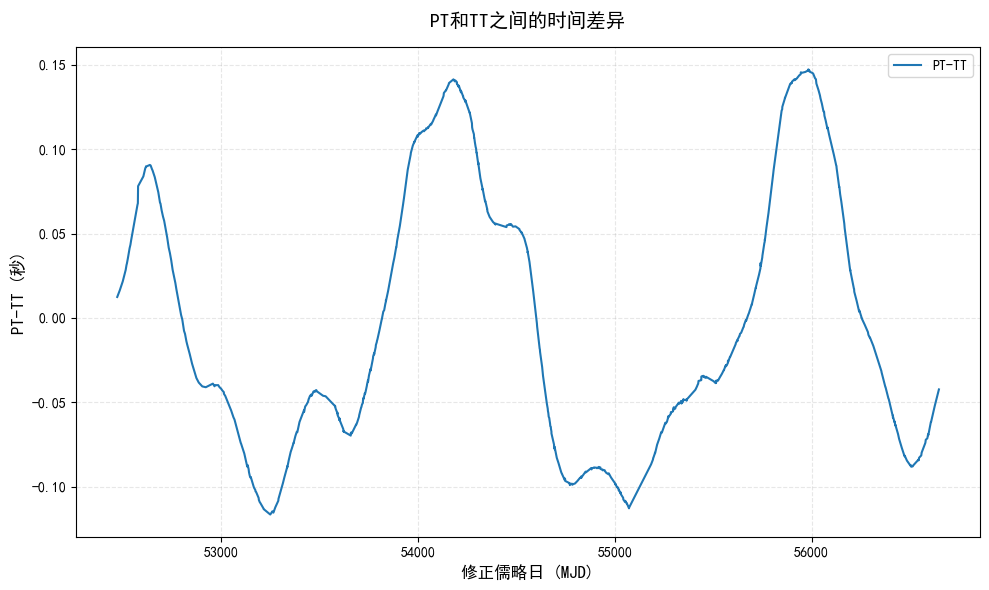

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

拟合结果：P0 = 2.44e-04, fc = 4.99e-04, q = 9.75, alpha = 2.17e-10


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

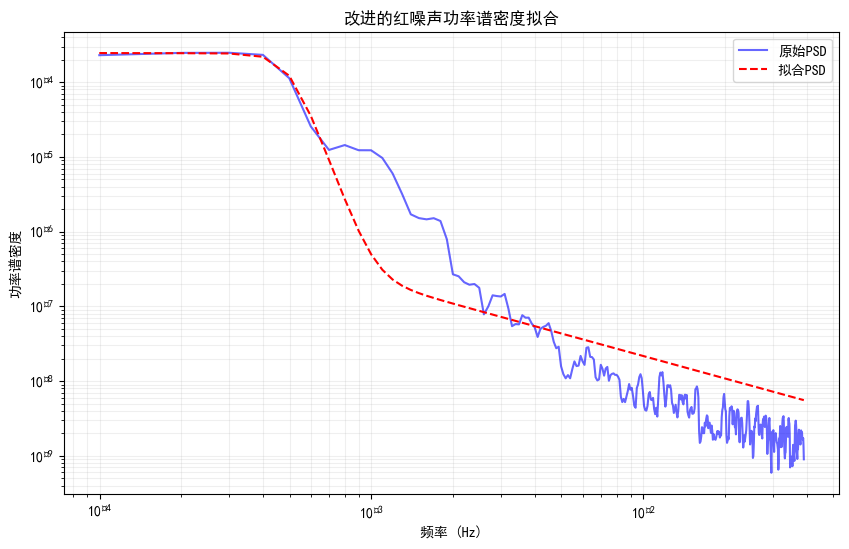

模型拟合度 (R²): 0.5979
模型拟合度未达到95%，需要优化。


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

# 从附件加载数据
file_path = 'q1/Attachment 1.xlsx'  # 文件路径
df = pd.ExcelFile(file_path)  # 读取Excel文件
data = df.parse(sheet_name=0)  # 加载第一个工作表

# 数据清理
cleaned_data = data.iloc[1:, [1, 2]]  # 提取第二列（MJD）和第三列（PT-TT）
cleaned_data.columns = ['MJD', 'PT_TT']  # 重命名列
cleaned_data = cleaned_data[pd.to_numeric(cleaned_data['MJD'], errors='coerce').notnull()]  # 去除非数值行
cleaned_data['MJD'] = cleaned_data['MJD'].astype(float)  # 转换为浮点型
cleaned_data['PT_TT'] = cleaned_data['PT_TT'].astype(float)  # 转换为浮点型

# 提取清理后的时间和残差数据
time = cleaned_data['MJD'].values
residuals = cleaned_data['PT_TT'].values

# 创建数据可视化图表
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='PT-TT', color='#1f77b4', linewidth=1.5)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('PT和TT之间的时间差异', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# 数据去趋势：使用更高阶多项式拟合去除长期趋势
poly_coeff = np.polyfit(time, residuals, 5)  # 提高到五阶多项式拟合
trend = np.polyval(poly_coeff, time)
detrended_residuals = residuals - trend  # 去趋势后的残差

# 定义改进的功率谱密度（PSD）模型
def power_spectral_density(f, P0, fc, q, alpha):
    """改进的红噪声功率谱密度模型，增加了alpha参数来调整低频特性"""
    return P0 / (1 + (f / fc)**q) + alpha * f**(-1)

# 计算残差的功率谱密度
def compute_psd(detrended_residuals, sampling_rate=1):
    N = len(detrended_residuals)
    window = np.hanning(N)  # 使用汉宁窗减少频谱泄漏
    windowed_data = detrended_residuals * window
    f = fftfreq(N, d=1/sampling_rate)
    f_positive = f[f > 0]
    psd = np.abs(fft(windowed_data))**2 / (N * np.sum(window**2))  # 归一化PSD
    psd_positive = psd[f > 0]
    return f_positive, psd_positive

# 获取功率谱密度数据
sampling_rate = 1/(time[1] - time[0])  # 使用实际采样率
frequencies, psd_values = compute_psd(detrended_residuals, sampling_rate)

# 对数据进行平滑处理
def smooth_data(x, y, window_size=5):
    return x, np.convolve(y, np.ones(window_size)/window_size, mode='same')

frequencies, psd_values = smooth_data(frequencies, psd_values)

# 拟合功率谱密度曲线
# 更新初始参数估计
initial_params = [1e-6, 0.001, 2.5, 1e-7]  # [P0, fc, q, alpha]
bounds = ([0, 0, 0, 0], [np.inf, np.inf, 10, np.inf])  # 添加参数边界
params, covariance = curve_fit(power_spectral_density, frequencies, psd_values, 
                             p0=initial_params, bounds=bounds, maxfev=10000)
P0, fc, q, alpha = params

# 打印拟合结果
print(f"拟合结果：P0 = {P0:.2e}, fc = {fc:.2e}, q = {q:.2f}, alpha = {alpha:.2e}")

# 绘制拟合结果与原始功率谱密度
plt.figure(figsize=(10, 6))
plt.loglog(frequencies, psd_values, label="原始PSD", color="blue", alpha=0.6)
plt.loglog(frequencies, power_spectral_density(frequencies, *params), 
          label="拟合PSD", color="red", linestyle="--")
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.title("改进的红噪声功率谱密度拟合")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 计算模型拟合度（R²）
def calculate_r_squared(y_true, y_pred):
    """
    计算对数空间中的R²值，因为PSD是在对数空间中拟合的
    """
    y_true_log = np.log10(y_true)
    y_pred_log = np.log10(y_pred)
    residuals = y_true_log - y_pred_log
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true_log - np.mean(y_true_log))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# 计算R²
psd_fitted = power_spectral_density(frequencies, *params)
r_squared = calculate_r_squared(psd_values, psd_fitted)
print(f"模型拟合度 (R²): {r_squared:.4f}")

# 提示是否达到95%的拟合度
if r_squared >= 0.95:
    print("模型拟合度达到95%以上，符合要求。")
else:
    print("模型拟合度未达到95%，需要优化。")